# Урок 6. Feature Engineering, Feature Selection, part II

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

Задание 3: использовать permutation importance, выполнить задание 1 и 2.

Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

Задание 5: использовать shap, выполнить задание 1 и 2.

Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.


In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import metrics
from datetime import timedelta
from datetime import datetime

from sklearn.model_selection import train_test_split
# from sunbird.categorical_encoding import frequency_encoding
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import scipy.stats as st

from eli5.sklearn import PermutationImportance
from eli5 import show_weights

import warnings
warnings.simplefilter("ignore")

import warnings
from tqdm import tqdm
from typing import List, Tuple

from scipy.stats import ttest_rel

# from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

warnings.simplefilter("ignore")
%matplotlib inline

In [3]:
public_df = pd.read_csv('assignment_2_train_1.csv')

In [4]:
print("public_df.shape = {} rows, {} cols".format(*public_df.shape))

public_df.shape = 180000 rows, 412 cols


In [5]:
public_df.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,card2_freq_enc,card3_freq_enc,card4_freq_enc,card5_freq_enc,card6_freq_enc,addr1_freq_enc,addr2_freq_enc,TransactionAmt_d,TransactionAmt_c,TransactionAmt_log
0,2987000,0,68.5,W,13926,0.0,150.0,discover,142.0,credit,...,0.014506,0.879722,0.013212,0.000272,0.317951,0.038156,0.876289,0.5,68.0,4.226834
1,2987001,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.006756,0.879722,0.302797,0.054433,0.317951,0.071367,0.876289,0.0,29.0,3.367296
2,2987002,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,0.060522,0.879722,0.657224,0.079844,0.681949,0.041217,0.876289,0.0,59.0,4.077537
3,2987003,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,0.009867,0.879722,0.302797,0.037106,0.681949,0.015411,0.876289,0.0,50.0,3.912023
4,2987004,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.030389,0.879722,0.302797,0.054433,0.317951,0.006967,0.876289,0.0,50.0,3.912023


In [6]:
# Получим список катероиальных и числовых признаков.
categorical = []
numerical = []
for col, value in public_df.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
    else:
        numerical.append(col)

In [7]:
 # Выделим числовые и категриальные переменные. 
public_df[categorical]=public_df[categorical].astype('category')


In [8]:
evalute_model_results = {
    'model_name': [],
    'Train-score': [],
    'Val-score': [],
    'Test-score': []
}

In [18]:
def evalute_model(df, categorical, model_name=""):

    categorical_1= [] 
    for c in categorical:
        if c in df.columns:
            categorical_1.append(c)
    # def label_encoder(self):

    le = LabelEncoder()
    for feature in categorical_1:
        cat_value = list(df[feature].values.astype('str'))
        le.fit(cat_value)
        df[feature] = le.transform(cat_value)

    # return self.X
 # Разделим выборки на тренировчную, тестовую и валидационную.
    x_train, x_test = train_test_split(df.drop(["TransactionID", "isFraud"], axis=1), train_size=0.60, shuffle=False, random_state=1)
    y_train, y_test = train_test_split(df["isFraud"], train_size=0.60, shuffle=False, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

    x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=False, random_state=1,)
    y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=False, random_state=1,)


    

    params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "reg_lambda": 50,
    "max_depth": 4,
    'random_state':1    
    }

    model = lgb.LGBMClassifier(**params)

    model.fit(
        X=x_train,
        y=y_train,
        eval_set=[(x_val, y_val), (x_val, y_val)],
        early_stopping_rounds=50,
        categorical_feature=categorical_1,
      # num_boost_round=10000,
        eval_metric="auc",
        verbose=50
    )

    train_score =  roc_auc_score(y_train, model.predict(x_train))
    val_score = roc_auc_score(y_val, model.predict(x_val))
    test_score = roc_auc_score(y_test, model.predict(x_test))
   
    print(f"\r\n Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")
  
  # Заполним словарь c результатами обучения модели.
    evalute_model_results['model_name'].append(model_name)
    evalute_model_results['Train-score'].append(round(train_score, 3))
    evalute_model_results['Test-score'].append(round(test_score, 3))
    evalute_model_results['Val-score'].append(round(val_score, 3))
    
    return model

In [19]:
base_model= evalute_model(df=public_df, categorical=categorical, model_name='Base_line')

[50]	valid_0's auc: 0.873796	valid_1's auc: 0.873796
[100]	valid_0's auc: 0.880737	valid_1's auc: 0.880737
[150]	valid_0's auc: 0.884498	valid_1's auc: 0.884498
[200]	valid_0's auc: 0.886661	valid_1's auc: 0.886661
[250]	valid_0's auc: 0.889006	valid_1's auc: 0.889006
[300]	valid_0's auc: 0.890411	valid_1's auc: 0.890411
[350]	valid_0's auc: 0.891439	valid_1's auc: 0.891439
[400]	valid_0's auc: 0.892002	valid_1's auc: 0.892002
[450]	valid_0's auc: 0.89311	valid_1's auc: 0.89311
[500]	valid_0's auc: 0.893373	valid_1's auc: 0.893373

 Train-score: 0.753, Val-score: 0.677, Test-score: 0.662


## Задание 1.

Использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

importance_type (str, optional (default="auto")) – How the importance is calculated. If “auto”, if booster parameter is LGBMModel, booster.importance_type attribute is used; “split” otherwise. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

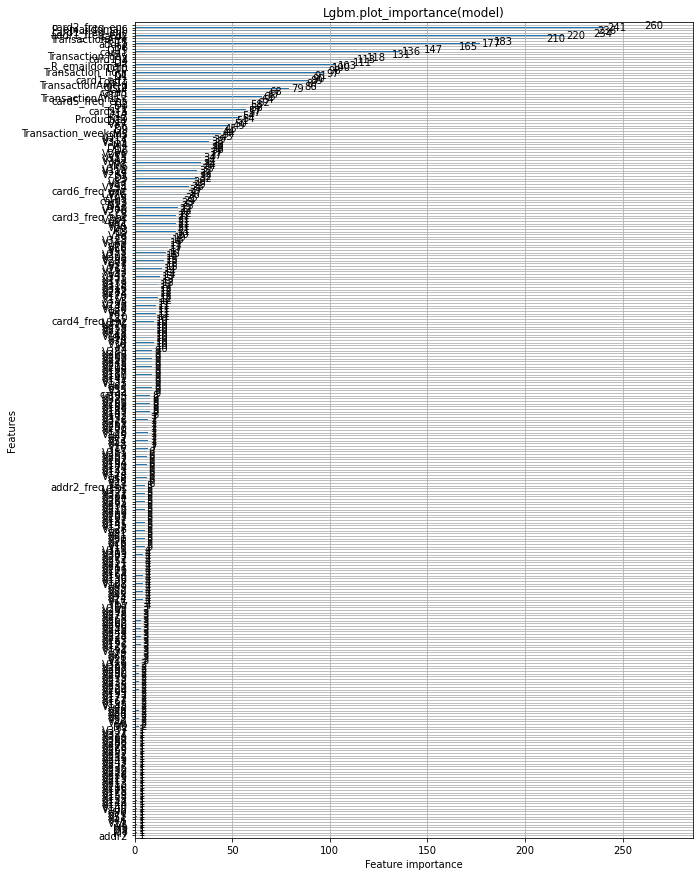

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
lgb.plot_importance(base_model, ax=ax, importance_type='auto')
plt.title("Lgbm.plot_importance(model)")
plt.show()

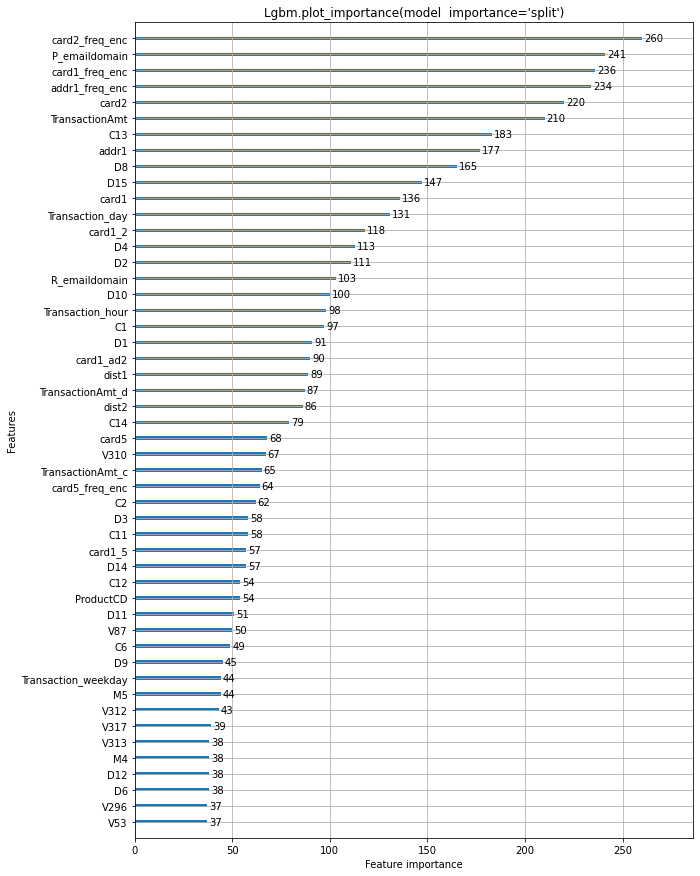

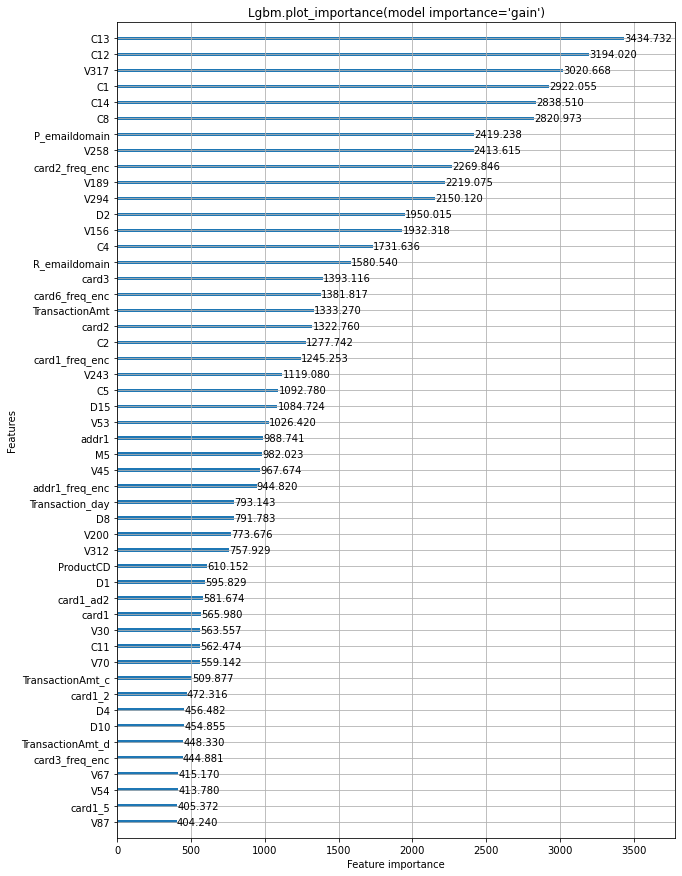

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
lgb.plot_importance(base_model, ax=ax, importance_type='split', max_num_features=50)
plt.title("Lgbm.plot_importance(model  importance='split')")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
lgb.plot_importance(base_model, ax=ax, importance_type='gain', max_num_features=50)
plt.title("Lgbm.plot_importance(model importance='gain')")
plt.show()

### Задание 2

удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [13]:
values= base_model.feature_importances_

In [16]:
importance = pd.DataFrame({
    "feature": public_df.drop(["TransactionID", "isFraud"], axis=1).columns,
    "importance": base_model.feature_importances_
})

In [17]:
importance_features= list(importance.loc[(importance['importance']>0), 'feature'].values)

In [19]:
importance_features.append('TransactionID')
importance_features.append('isFraud')

In [22]:
evalute_model(df=public_df[importance_features], categorical=categorical, model_name='ligth_gbm_score')

[50]	valid_0's auc: 0.875708	valid_1's auc: 0.875708
[100]	valid_0's auc: 0.881856	valid_1's auc: 0.881856
[150]	valid_0's auc: 0.884572	valid_1's auc: 0.884572
[200]	valid_0's auc: 0.887244	valid_1's auc: 0.887244
[250]	valid_0's auc: 0.889253	valid_1's auc: 0.889253
[300]	valid_0's auc: 0.891308	valid_1's auc: 0.891308
[350]	valid_0's auc: 0.891914	valid_1's auc: 0.891914
[400]	valid_0's auc: 0.892681	valid_1's auc: 0.892681
[450]	valid_0's auc: 0.893914	valid_1's auc: 0.893914

 Train-score: 0.748, Val-score: 0.67, Test-score: 0.661


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

In [23]:
importance_features= list(importance.loc[(importance['importance']>5), 'feature'].values)
importance_features.append('TransactionID')
importance_features.append('isFraud')

In [24]:
evalute_model(df=public_df[importance_features], categorical=categorical, model_name='ligth_gbm_score')

[50]	valid_0's auc: 0.877096	valid_1's auc: 0.877096
[100]	valid_0's auc: 0.882273	valid_1's auc: 0.882273
[150]	valid_0's auc: 0.886724	valid_1's auc: 0.886724
[200]	valid_0's auc: 0.888232	valid_1's auc: 0.888232
[250]	valid_0's auc: 0.890141	valid_1's auc: 0.890141
[300]	valid_0's auc: 0.890935	valid_1's auc: 0.890935
[350]	valid_0's auc: 0.89241	valid_1's auc: 0.89241
[400]	valid_0's auc: 0.893683	valid_1's auc: 0.893683
[450]	valid_0's auc: 0.89383	valid_1's auc: 0.89383

 Train-score: 0.742, Val-score: 0.673, Test-score: 0.661


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

In [25]:
importance_features= list(importance.loc[(importance['importance']>10), 'feature'].values)
importance_features.append('TransactionID')
importance_features.append('isFraud')

In [26]:
evalute_model(df=public_df[importance_features], categorical=categorical, model_name='ligth_gbm_score')

[50]	valid_0's auc: 0.87473	valid_1's auc: 0.87473
[100]	valid_0's auc: 0.883116	valid_1's auc: 0.883116
[150]	valid_0's auc: 0.885329	valid_1's auc: 0.885329
[200]	valid_0's auc: 0.886878	valid_1's auc: 0.886878
[250]	valid_0's auc: 0.889128	valid_1's auc: 0.889128
[300]	valid_0's auc: 0.89023	valid_1's auc: 0.89023
[350]	valid_0's auc: 0.892596	valid_1's auc: 0.892596
[400]	valid_0's auc: 0.894175	valid_1's auc: 0.894175
[450]	valid_0's auc: 0.894047	valid_1's auc: 0.894047
[500]	valid_0's auc: 0.895091	valid_1's auc: 0.895091

 Train-score: 0.754, Val-score: 0.672, Test-score: 0.665


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

## Задание 3
 
 использовать permutation importance, выполнить задание 1 и 2.


In [20]:
# Разделим выборки на тренировчную, тестовую и валидационную.
x_train, x_test = train_test_split(public_df.drop(["TransactionID", "isFraud"], axis=1), train_size=0.60, shuffle=False, random_state=1)
y_train, y_test = train_test_split(public_df["isFraud"], train_size=0.60, shuffle=False, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=False, random_state=1,)
y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=False, random_state=1,)

In [21]:
le = LabelEncoder()
for feature in categorical:
    cat_value = list(x_val[feature].values.astype('str'))
    le.fit(cat_value)
    x_val[feature] = le.transform(cat_value)

In [22]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(
   base_model, x_val, y_val, scoring="roc_auc", n_jobs=6, random_state=27
)

In [23]:
importance_scores = pd.DataFrame({
    "features": x_val.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)
decrease_scores

,features,importance-mean,importance-std
0,V190,0.000000,0.000000
1,addr2_freq_enc,0.000000,0.000000
2,V319,0.000000,0.000000
3,Transaction_year,0.000000,0.000000
4,V192,0.000000,0.000000
...,...,...,...
219,M4,-0.001212,0.001858
220,V156,-0.001707,0.000234
221,P_emaildomain,-0.001754,0.001235
222,V335,-0.002439,0.000167


In [25]:
estimator = PermutationImportance( base_model, scoring="roc_auc", random_state=27)

importance = estimator.fit(x_val.fillna(-9999), y_val)

In [26]:
show_weights(importance, feature_names=x_val.columns.tolist(), top=x_val.shape[1])

Weight,Feature
0.0250 ± 0.0022,C13
0.0120 ± 0.0018,C1
0.0102 ± 0.0008,V317
0.0096 ± 0.0034,M4
0.0095 ± 0.0014,card2_freq_enc
0.0087 ± 0.0013,R_emaildomain
0.0076 ± 0.0013,C14
0.0062 ± 0.0031,D2
0.0050 ± 0.0013,M5
0.0041 ± 0.0012,card6_freq_enc


In [30]:
importance = pd.DataFrame({
    "feature": public_df.drop(["TransactionID", "isFraud"], axis=1).columns,
    "importance": importance.feature_importances_
})

In [31]:
importance_features= list(importance.loc[(np.abs(importance['importance'])>0), 'feature'].values)
importance_features.append('TransactionID')
importance_features.append('isFraud')

In [34]:
evalute_model(df=public_df[importance_features], categorical=categorical, model_name='ligth_gbm_score')

[50]	valid_0's auc: 0.872447	valid_1's auc: 0.872447
[100]	valid_0's auc: 0.880897	valid_1's auc: 0.880897
[150]	valid_0's auc: 0.883997	valid_1's auc: 0.883997
[200]	valid_0's auc: 0.886052	valid_1's auc: 0.886052
[250]	valid_0's auc: 0.88796	valid_1's auc: 0.88796
[300]	valid_0's auc: 0.889454	valid_1's auc: 0.889454
[350]	valid_0's auc: 0.890007	valid_1's auc: 0.890007
[400]	valid_0's auc: 0.890803	valid_1's auc: 0.890803
[450]	valid_0's auc: 0.89166	valid_1's auc: 0.89166
[500]	valid_0's auc: 0.8921	valid_1's auc: 0.8921

 Train-score: 0.757, Val-score: 0.676, Test-score: 0.662


LGBMClassifier(max_depth=4, metric='auc', n_estimators=10000,
               objective='binary', random_state=1, reg_lambda=50)

## Задание 4

использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.
